Basado en: "Using networks and partial differential equations
to forecast bitcoin price movement", by Yufang Wang and  Haiyan Wang.

In [ ]:
!pip install scikit-learn

In [ ]:
import yfinance as yf
import numpy as np
from scipy.interpolate import CubicSpline
from scipy.optimize import minimize
from random import random
import pandas as pd
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def getGTrendIndex(year):
    google_trend_data='/content/drive/My Drive/ProyectoNumerico3/GTrendIndex' + str(year) +'.txt'
    weekly_trend_index=np.loadtxt(google_trend_data)
    #Google only provides weekly reports, so we asume that index as an average of two consecutive weeks
    av_weekly_trend_index = [(weekly_trend_index[i] + weekly_trend_index[i+1]) / 2 for i in range(len(weekly_trend_index)-1)]
    daily_trend_index = []
    for index in av_weekly_trend_index:
        daily_trend_index.extend([index] * 7)
    daily_trend_index.append(daily_trend_index[-1])
    return daily_trend_index

In [ ]:
#Datos obtenidos de https://github.com/cakcora/CoinWorks
#Descargamos los chainlet
def getChainlet(year):
    archivo_txt = '/content/drive/My Drive/ProyectoNumerico3/Edit_AmoChainlet.txt'
    datos = pd.read_csv(archivo_txt, delimiter='\t')

    # Filtra las filas correspondientes al año 2017 y elimina las primeras
    # 3 columnas que no son necesarias
    datos_year = datos[datos.iloc[:, 0] == year]
    datos=np.array(datos_year)
    datos=datos[:,3:]

    #Estructuramos los datos
    #Cada columna corresponde a un chainlet x:y
    chainlets=[]
    for i in range(400):
        chainlets.append(datos[:,i])
    chainlets=np.array(chainlets)
    return datos

In [ ]:
def Chainlet_Spectral_Clustering(chainlets):
    # Aplicar un escalado estándar a los datos
    scaler = StandardScaler()
    chainlets_scaled = scaler.fit_transform(chainlets)

    # Número de clusters deseados
    num_clusters = 10

    # Aplicar Spectral Clustering
    spectral = SpectralClustering(n_clusters=num_clusters, affinity='nearest_neighbors', n_neighbors=10)
    labels = spectral.fit_predict(chainlets_scaled)

    clusters = [[] for _ in range(num_clusters)]

    #Organizamos los cluster en un vector
    for i, label in enumerate(labels):
        clusters[label].append(chainlets[i])

    cluster_similarity_matrix = np.zeros((num_clusters, num_clusters))

    for i in range(num_clusters):
        for j in range(num_clusters):
            # Puedes usar cualquier medida de similitud que prefieras, aquí se usa la distancia euclidiana
            similarity = pairwise_distances([np.mean(clusters[i], axis=0)], [np.mean(clusters[j], axis=0)])
            cluster_similarity_matrix[i, j] = similarity

    # Encontrar el orden de los clusters basado en la similitud
    cluster_order = np.argsort(np.sum(cluster_similarity_matrix, axis=0))

    # Reorganizar el vector clusters según el nuevo orden
    cluster = [clusters[i] for i in cluster_order]
    return cluster

In [ ]:
def sumatoria(lista):
    suma1=0
    for i in range(len(lista)):
        suma1+=lista[i]
    return suma1

In [ ]:
def TranVol(cluster):
    #Vemos el volumen de transaccion por cluster
    transaction_vol=np.zeros(10)
    for i in range(10):
        volume=0
        for j in range(len(cluster[i])):
            volume+=sumatoria(cluster[i][j])
        transaction_vol[i]=volume
    return transaction_vol

In [ ]:
def Tran_Vol_Graph(transaction_vol):
    plt.figure(figsize=(16, 9))
    plt.bar(range(len(transaction_vol)), transaction_vol, edgecolor='black')
    plt.xlabel('Cluster n°')
    plt.title('Transaction Volume per Cluster')
    plt.show()

In [ ]:
def AvDailyTranVol(cluster):
    #Vemos el promedio diario de transacciones por cluster
    av_vol_clus_t=[]
    for k in range(10):
        sol=[]
        for i in range(365):
            suma=0
            n=len(cluster[k])
            for j in range(n):
                suma+=cluster[k][j][i]
            suma/=n
            sol.append(suma)
        av_vol_clus_t.append(sol)
    return av_vol_clus_t

In [ ]:
def AvTranVolGraph(av_vol_clus_t):
    fig, ax = plt.subplots(figsize=(16,9))
    times=np.array([i for i in range(1,366)])
    col=[0,0,0,0,"lightblue",0,"pink",0,0,0]
    for i in [4,6]:
        clus=av_vol_clus_t[i]
        n=len(clus)
        for j in range(n):
            if clus[j]==0:
                clus[j]=clus[j+1] if j!=n-1 else clus[j-1]
        ax.plot(np.array(times), np.array(clus), color=col[i], label="custer n°" + str(i))

    plt.title("Log Average transaction volume per cluster")
    plt.yscale("log")
    ax.set_xlabel("Day")
    ax.grid(linewidth=0.1)
    plt.legend()
    plt.show()

In [ ]:
def ClusTranVol(cluster):
    #volumen de transaccion del cluster i en el tiempo t
    clus_tran_vol_t = [[0] * 365 for _ in range(10)]
    for i in range(10):
        for j in range(len(cluster[i])):
            for k in range(365):
                clus_tran_vol_t[i][k] += cluster[i][j][k]
    return clus_tran_vol_t


def TotalTranVol(clus_tran_vol_t):
    #volumen de transaccion total en el tiempo t
    total_tran_vol_t = [0] * 365
    for i in range(10):
        for k in range(365):
            total_tran_vol_t[k] += clus_tran_vol_t[i][k]
    return total_tran_vol_t

def getP(clus_tran_vol_t, total_tran_vol_t):
    #Definimos Po(x_i, t_j) = transaction vol per cluster x_i at time t_j / total transaction volume at time t_j
    P=np.zeros((10, 365))
    for x in range(10):
        for t in range(365):
            P[x,t]=clus_tran_vol_t[x][t]/total_tran_vol_t[t]
    return P



def getM(daily_trend_index, P):
    #Calculamos m(x_i, t_j)
    m_fun=np.zeros((10, 365))
    for x in range(10):
        for t in range(365):
            m_fun[x,t]= daily_trend_index[t] * P[x,t]
    return m_fun


In [ ]:
#Definimos el esquema de diferencias finitar para resolver
#T_final>=3
def Crank_Nicolson(x, d, phi, alfa, alfa_seg, r, k, b_0,T_final):
    t= T_final - 2 #usamos 2 dias para predecir el precio

    n = len(x)
    hx = np.abs(x[-1] - x[0]) / n
    ht = hx*10
    m = int((T_final - t) /ht)

    #Armamos la matriz
    sub_diag = -np.ones(n+1) * d*ht/hx/hx
    subdiag_matrix = np.diag(sub_diag,-1) + np.diag(sub_diag,1)
    A = np.zeros((n+2,n+2)) + np.eye(n+2) * (1+2*d*ht/hx/hx) + subdiag_matrix
    A[-1, -2:] = np.array([-1/2/hx, 1/2/hx])
    A[0,:2] = np.array([-1/2/hx, 1/2/hx])

    #Funciones para el vector F
    f = lambda x,t: (k * (alfa(x) **2) * r(t) / b_0) + (d / b_0 * alfa_seg(x))
    multiplicador = lambda x,t: k*alfa(x)*r(t)

    #Armamos la matriz con las soluciones
    sol = np.zeros((n,m))
    sol[:,0]= phi(x)


    F = np.zeros(n+2)

    for i in range(1,m):
        for j in range(n):
            X0 = sol[:,i-1].copy()
            X0[j] = X0[j] * multiplicador(x[j],t) + f(x[j],t)
            F[1:-1] = X0
        lineal_sol = np.linalg.solve(A,F)
        for j in range(n):
            sol[j,i] = lineal_sol[j]
        t += ht

    return sol

In [ ]:
#Resolvemos la ecuacion diferencial dada
def pde_solver(params, m_fun):
    d = params[0]
    b_0 = params[1]
    r = lambda t: params[2] + np.exp(-(t-params[3])**2)
    k = params[4]

    x = np.linspace(1,10,100)

    # Evaluar el spline en los puntos definidos
    alfa_i=params[5:]
    alfa=CubicSpline(list(range(1,11)), np.random.rand(10), bc_type='clamped') #clamped means a'(1)=a(10)=0
    alfa_seg = alfa.derivative(nu=2)

    Precios=np.zeros(52)
    i=0
    for T_final in list(range(1,366))[6::7]:
        phi=CubicSpline(list(range(1,11)), m_fun[:,T_final-2]) #=m(1,t)
        Predict = Crank_Nicolson(x, d, phi, alfa, alfa_seg, r, k, b_0, T_final)
        u_xt = b_0*Predict[:,-1]
        u_xt+=alfa(x)
        Precios[i] = np.trapz(u_xt,x)
        i+=1
    return Precios

In [ ]:
#Get data from a year
def getData(year):
    symbol = "BTC-USD"
    start_date = str(year) + '-01-01'
    end_date = str(year) + '-12-31'
    return yf.download(symbol, start=start_date, end=end_date)["Adj Close"][6::7]

In [ ]:
#Definimos la funcion de costo
def cost_function(params, m_fun, btc_price):
    # Obtener datos observados u_obs y ubicaciones x, t
    u_approx = pde_solver(params, m_fun)
    return np.linalg.norm(u_approx - btc_price)

def factor_cost_function(factor,pred, price):
    return np.linalg.norm(price - factor*pred)

In [ ]:
def getParam(m_fun,btc_price):
    #Minimizacion de funcion de costo
    initial_guess=np.random.rand(15)
    #Supongamos que x, t y u_obs son tus datos observados y ubicaciones
    result = minimize(cost_function, initial_guess, args=(m_fun,btc_price), method='L-BFGS-B')
    return result.x

def getFactor(pred, price):
    #Minimizacion de funcion de costo
    initial_guess=15
    #Supongamos que x, t y u_obs son tus datos observados y ubicaciones
    result = minimize(factor_cost_function, initial_guess, args=(pred,price,), method='L-BFGS-B')
    return result.x

In [ ]:
def CurrYearPredGraph(price_pred,btc_price, factor, year, err):
    fig, ax=plt.subplots(figsize=((16, 9)))
    ax.plot(list(range(1,366))[6::7], factor*price_pred, color="lightblue", label="Model Price")
    ax.plot(list(range(1,366))[6::7], btc_price, color="pink", label="Real Price")
    plt.title("Model Price vs Real Price "+str(year)+"  | Relative error = "+str(err)+"%")
    ax.set_xlabel("Day")
    ax.set_ylabel("Value")
    ax.grid(linewidth=0.1)
    plt.legend()
    plt.show()

In [ ]:
def relative_error(price_pred, factor, btc_price):
    diferencias_porcentuales= np.abs((price_pred*factor - btc_price) / btc_price) * 100
    diferencia_promedio = np.mean(diferencias_porcentuales)
    return diferencia_promedio, diferencias_porcentuales

In [ ]:
def pctErrorGraph(pct_rel_err,avg_rel_err):
    fig, ax=plt.subplots(figsize=(16,9))
    ax.plot(list(range(1,366))[6::7], pct_rel_err, color="lightblue", label="Weekly Error")
    ax.plot(list(range(1,366))[6::7], avg_rel_err*np.ones(len(pct_rel_err)), color="pink", label="Average Error")
    plt.title("Percentual Error")
    ax.set_xlabel("Day")
    ax.set_ylabel("Error%")
    ax.grid(linewidth=0.1)
    plt.legend()
    plt.show()

In [ ]:
def Quarter_HitError(price_pred, factor, btc_price):
    D = np.zeros_like(btc_price, dtype=int)
    # Calcular kigs según la condición dada
    for i in range(len(btc_price) - 1):
        if (btc_price[i+1] - btc_price[i]) * (factor*price_pred[i+1] - btc_price[i]) > 0:
            D[i] = 1
    per_quarter=[np.mean(D[:13]), np.mean(D[13:26]), np.mean(D[26:39]), np.mean(D[39:52])]
    return per_quarter

ANALISIS DE 2015

In [ ]:
chainlets=getChainlet(2015)
cluster= Chainlet_Spectral_Clustering(chainlets)
transaction_vol=TranVol(cluster)
av_vol_clus_t=AvDailyTranVol(cluster)

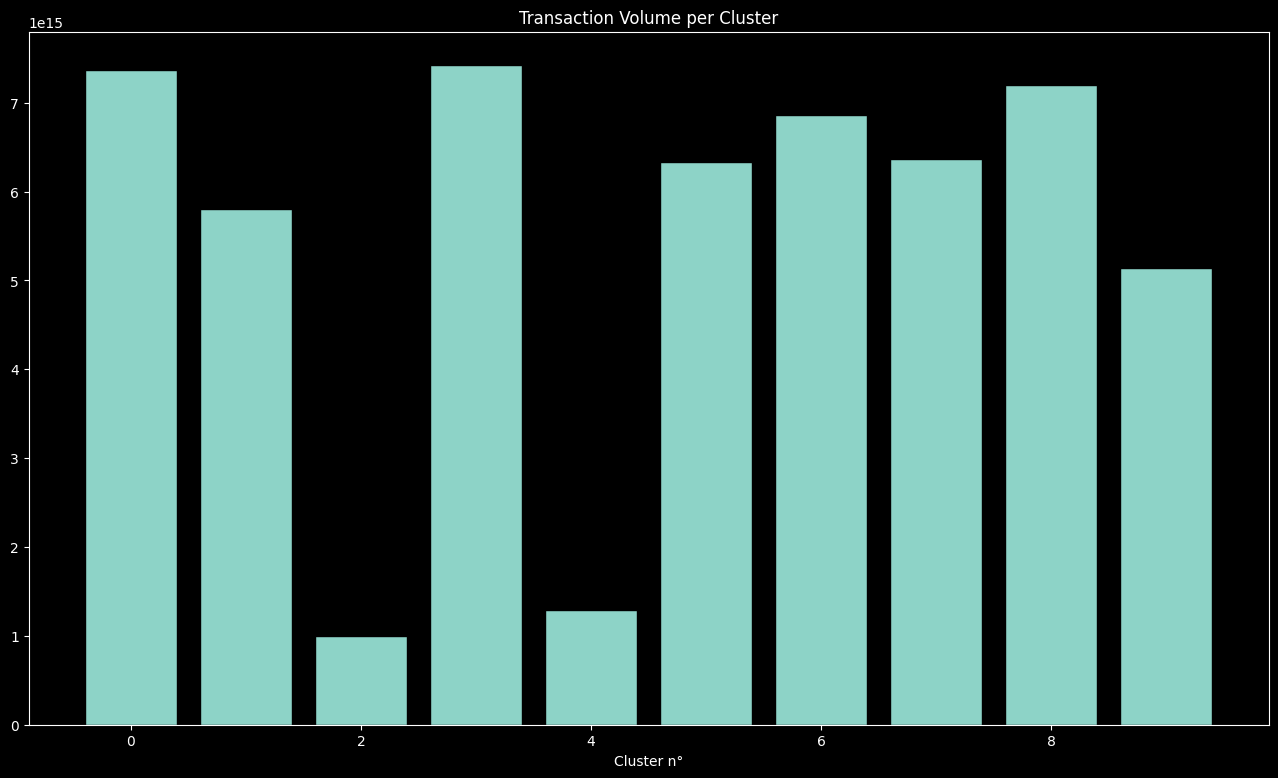

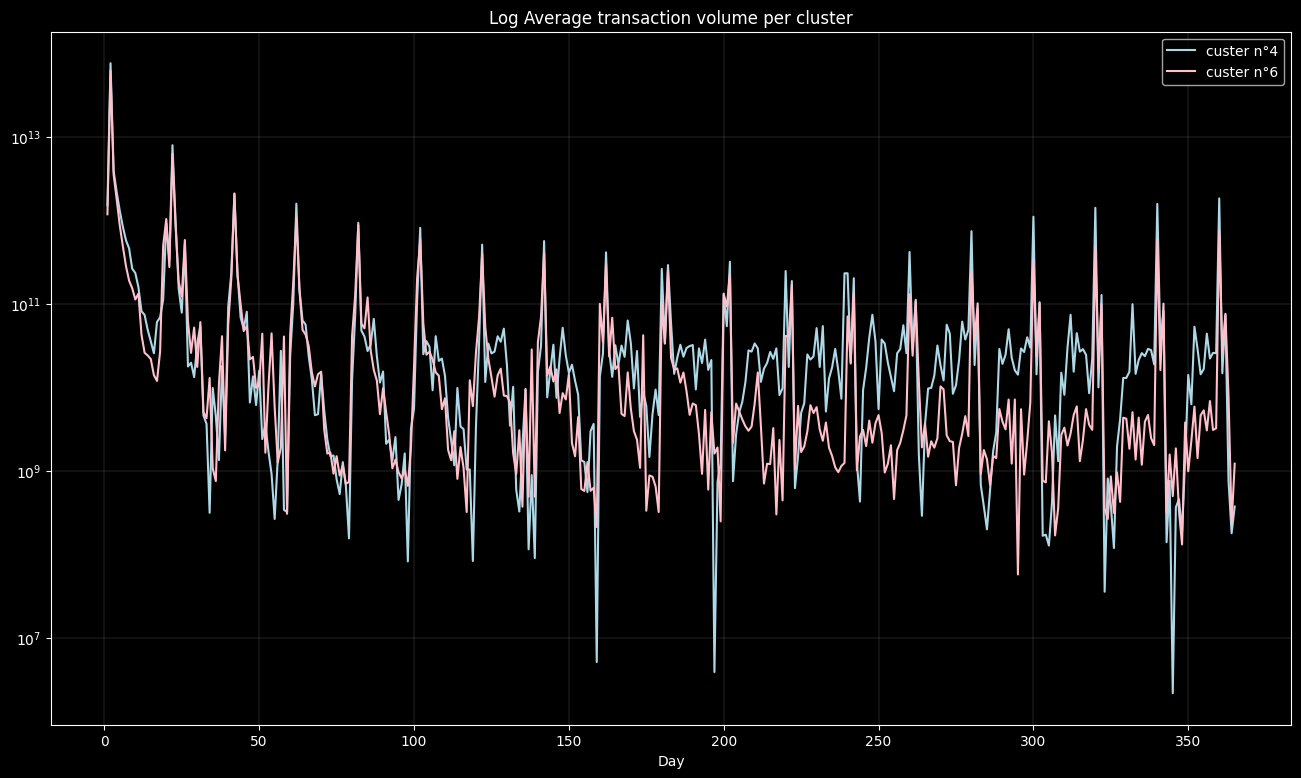

In [ ]:
plt.style.use("dark_background")
Tran_Vol_Graph(transaction_vol)
AvTranVolGraph(av_vol_clus_t)

In [ ]:
btc_price=getData(2015)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
daily_trend_index=getGTrendIndex(2015)
clus_tran_vol_t = ClusTranVol(cluster)
total_tran_vol_t=TotalTranVol(clus_tran_vol_t)
P= getP(clus_tran_vol_t, total_tran_vol_t)
m_fun=getM(daily_trend_index, P)

In [ ]:
param=getParam(m_fun,btc_price)

In [ ]:
price_pred=pde_solver(param, m_fun)
factor=getFactor(price_pred, btc_price)

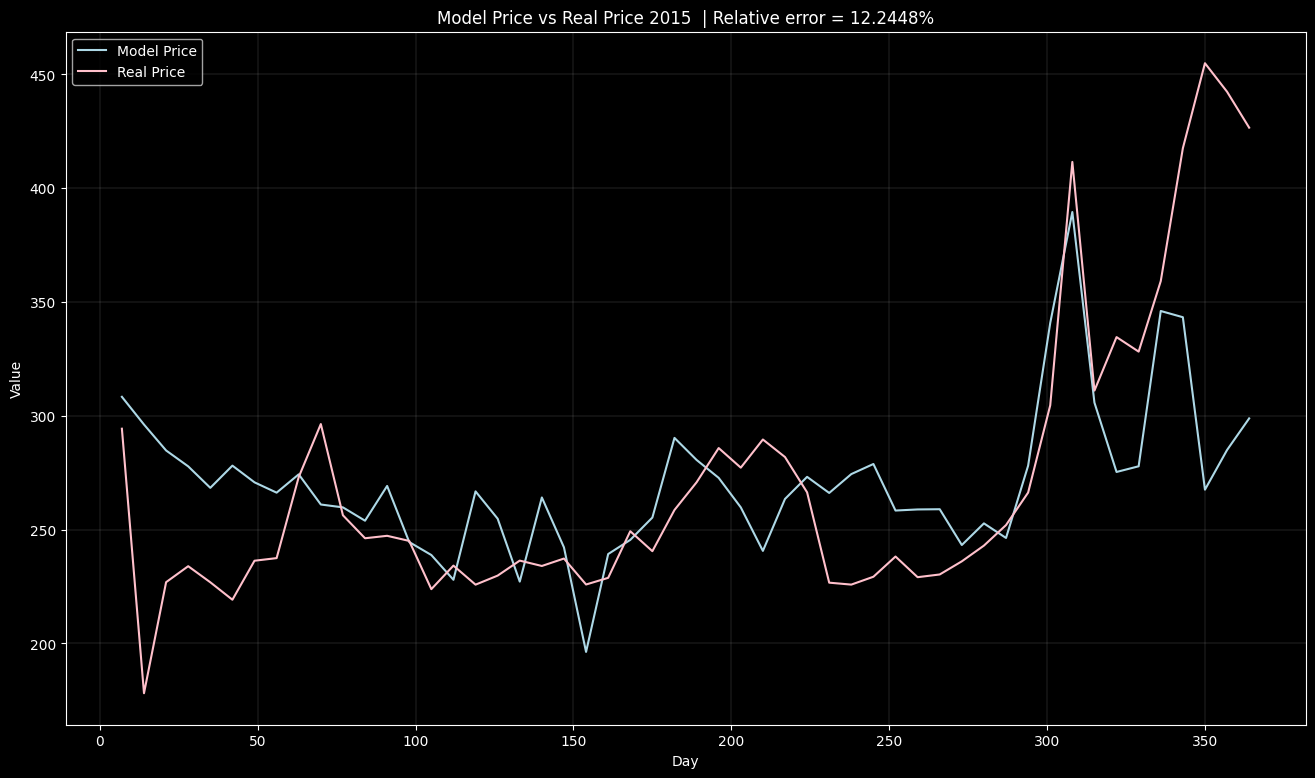

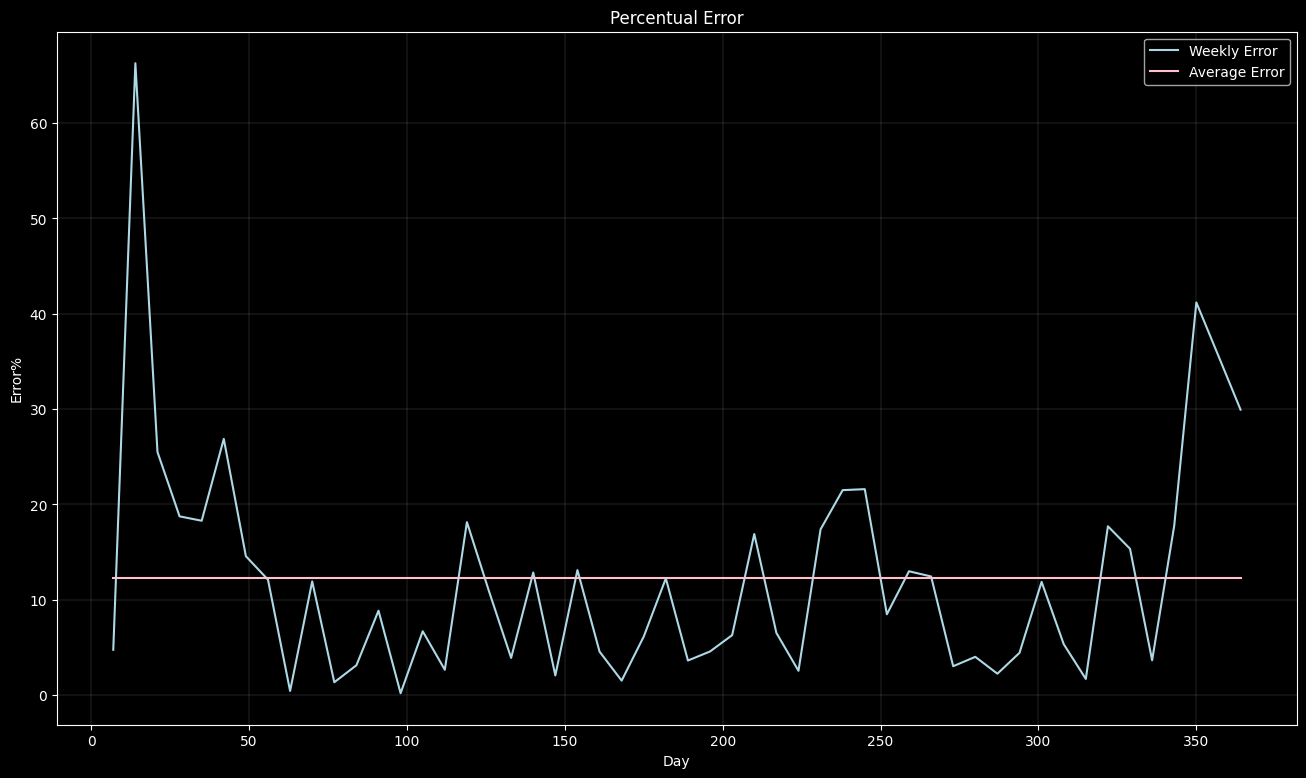

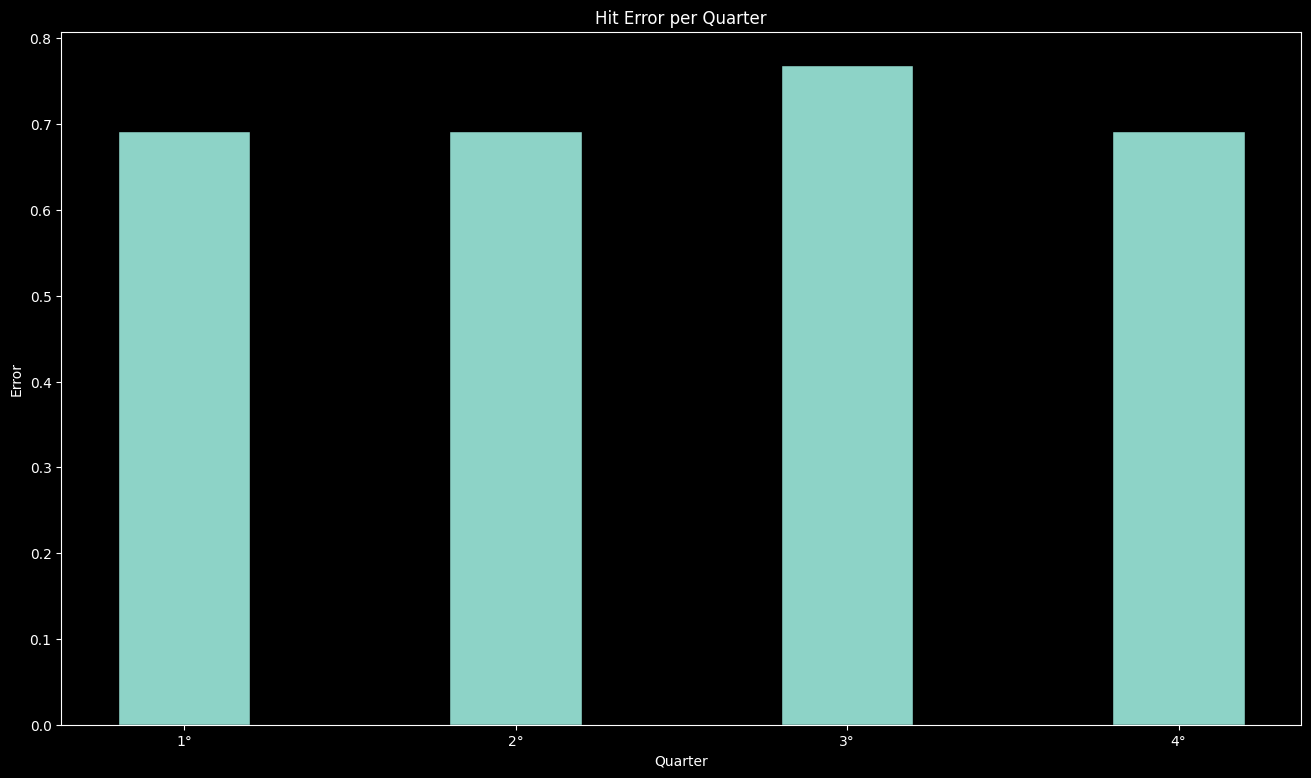

In [ ]:
avg_rel_err=relative_error(price_pred, factor, btc_price)[0]
pct_rel_err=relative_error(price_pred, factor, btc_price)[1]
H_error=Quarter_HitError(price_pred, factor, btc_price)

CurrYearPredGraph(price_pred,btc_price, factor, year=2015, err=round(avg_rel_err,4))
pctErrorGraph(pct_rel_err,avg_rel_err)
labels = ['1°', '2°', '3°', '4°']
plt.figure(figsize=(16, 9))
plt.bar(labels, H_error, edgecolor='black', width=0.4)
plt.title('Hit Error per Quarter')
plt.xlabel('Quarter')
plt.ylabel('Error')
plt.show()

VEMOS 2016 CON LOS PARAMETROS DE 2015

[*********************100%%**********************]  1 of 1 completed


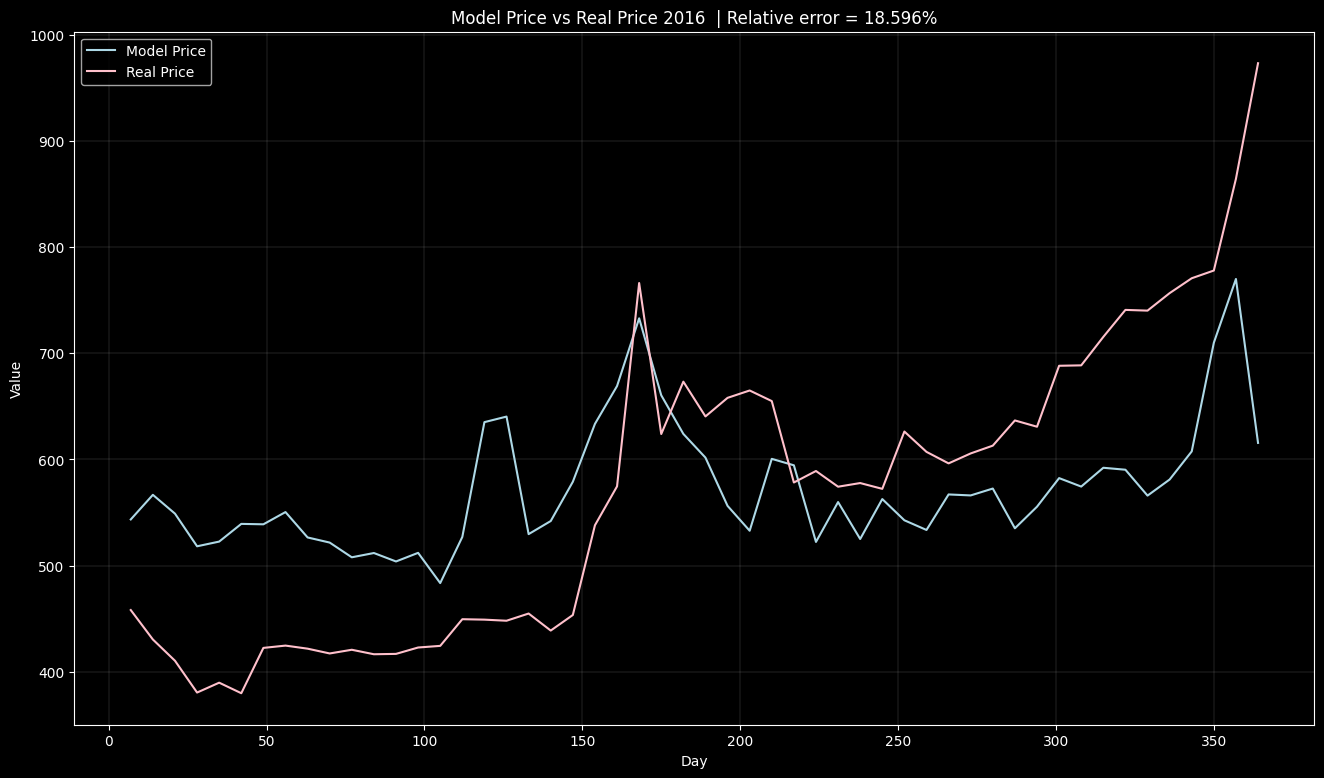

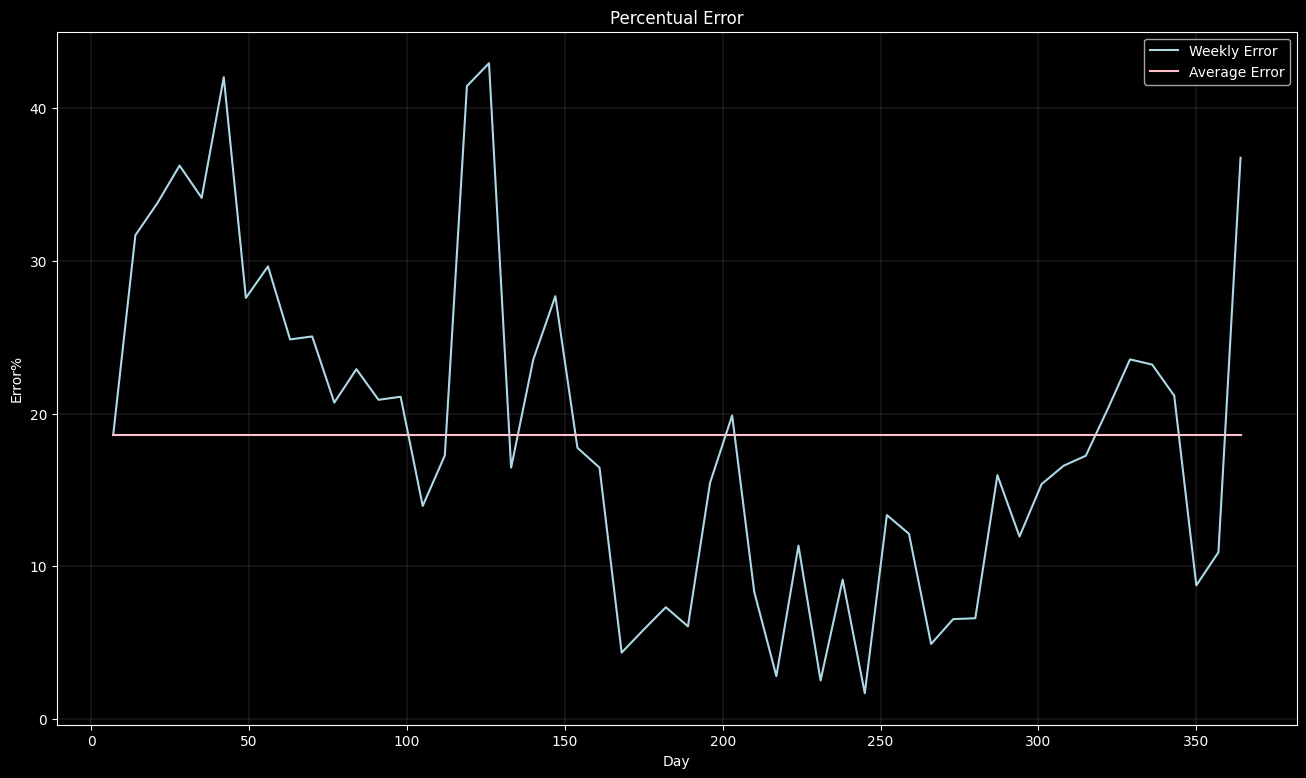

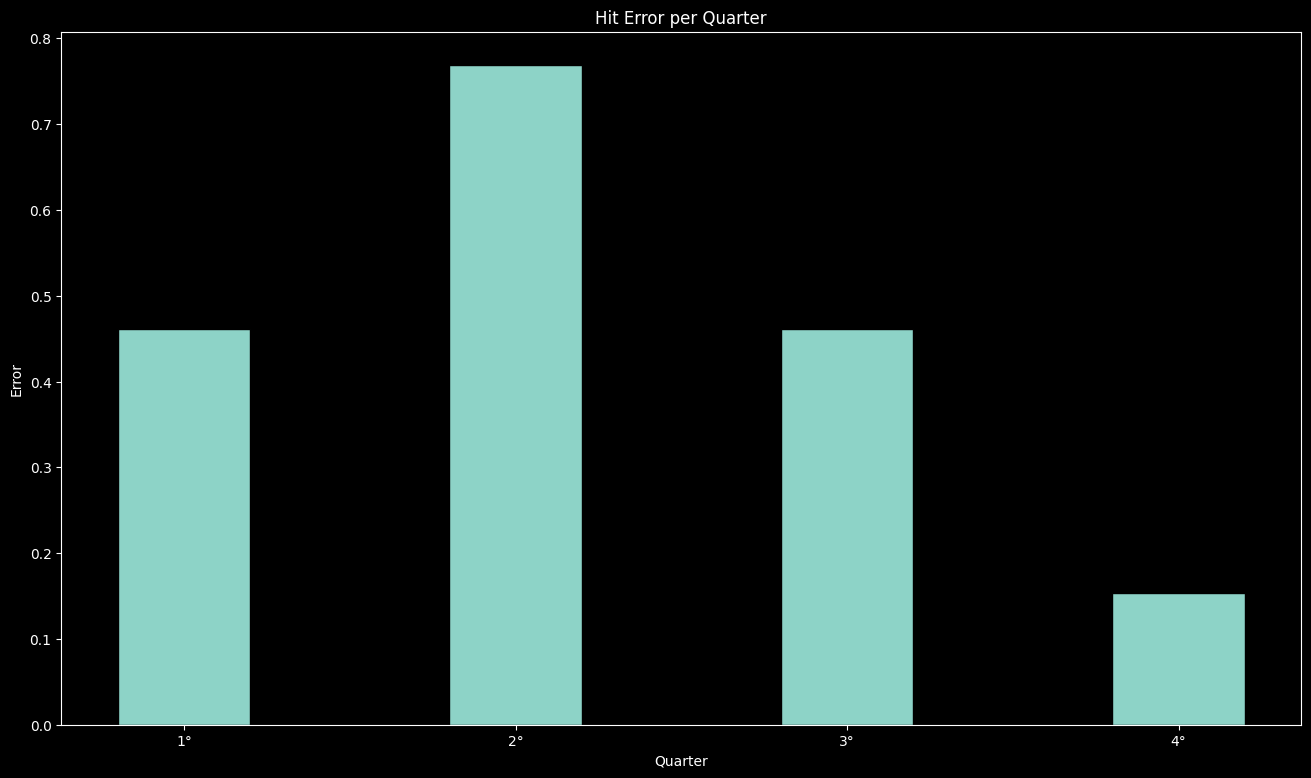

In [ ]:
chainlets=getChainlet(2016)
cluster= Chainlet_Spectral_Clustering(chainlets)
transaction_vol=TranVol(cluster)
av_vol_clus_t=AvDailyTranVol(cluster)
btc_price=getData(2016)
daily_trend_index=getGTrendIndex(2016)
clus_tran_vol_t = ClusTranVol(cluster)
total_tran_vol_t=TotalTranVol(clus_tran_vol_t)
P= getP(clus_tran_vol_t, total_tran_vol_t)
m_fun=getM(daily_trend_index, P)
price_pred=pde_solver(param, m_fun)
factor=getFactor(price_pred, btc_price)
avg_rel_err=relative_error(price_pred, factor, btc_price)[0]
pct_rel_err=relative_error(price_pred, factor, btc_price)[1]

CurrYearPredGraph(price_pred,btc_price, factor, year=2016, err=round(avg_rel_err,4))


pctErrorGraph(pct_rel_err,avg_rel_err)
H_error=Quarter_HitError(price_pred, factor, btc_price)
labels = ['1°', '2°', '3°', '4°']
plt.figure(figsize=(16, 9))
plt.bar(labels, H_error, edgecolor='black', width=0.4)
plt.title('Hit Error per Quarter')
plt.xlabel('Quarter')
plt.ylabel('Error')
plt.show()


VEMOS 2017 CON LOS PARAMETROS DE 2015

[*********************100%%**********************]  1 of 1 completed


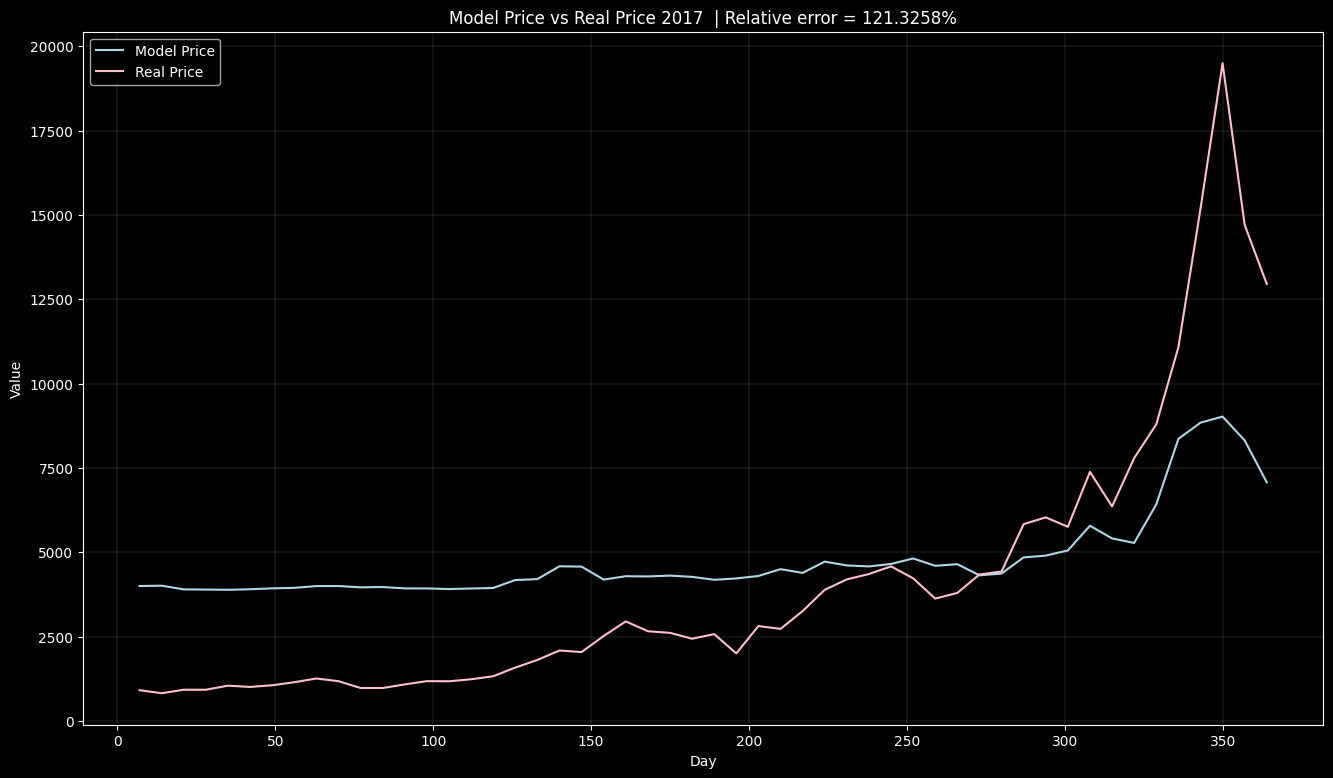

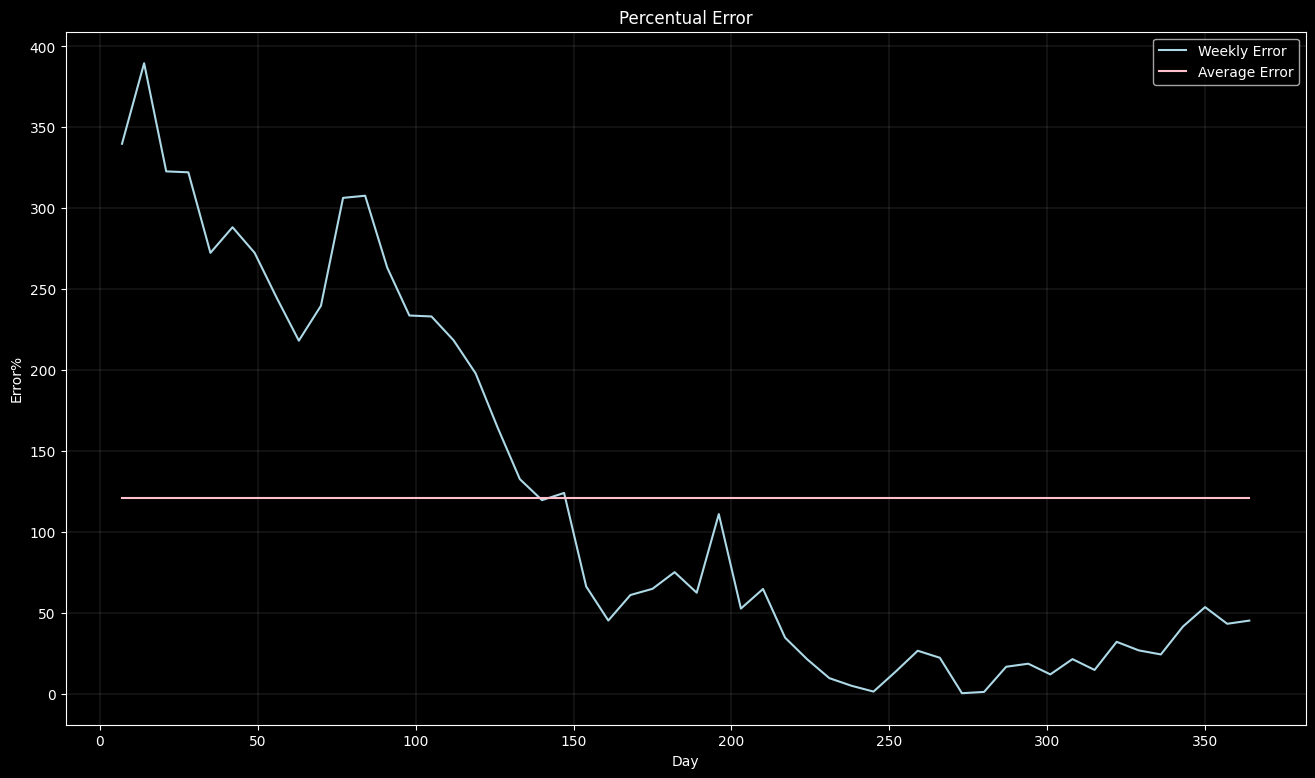

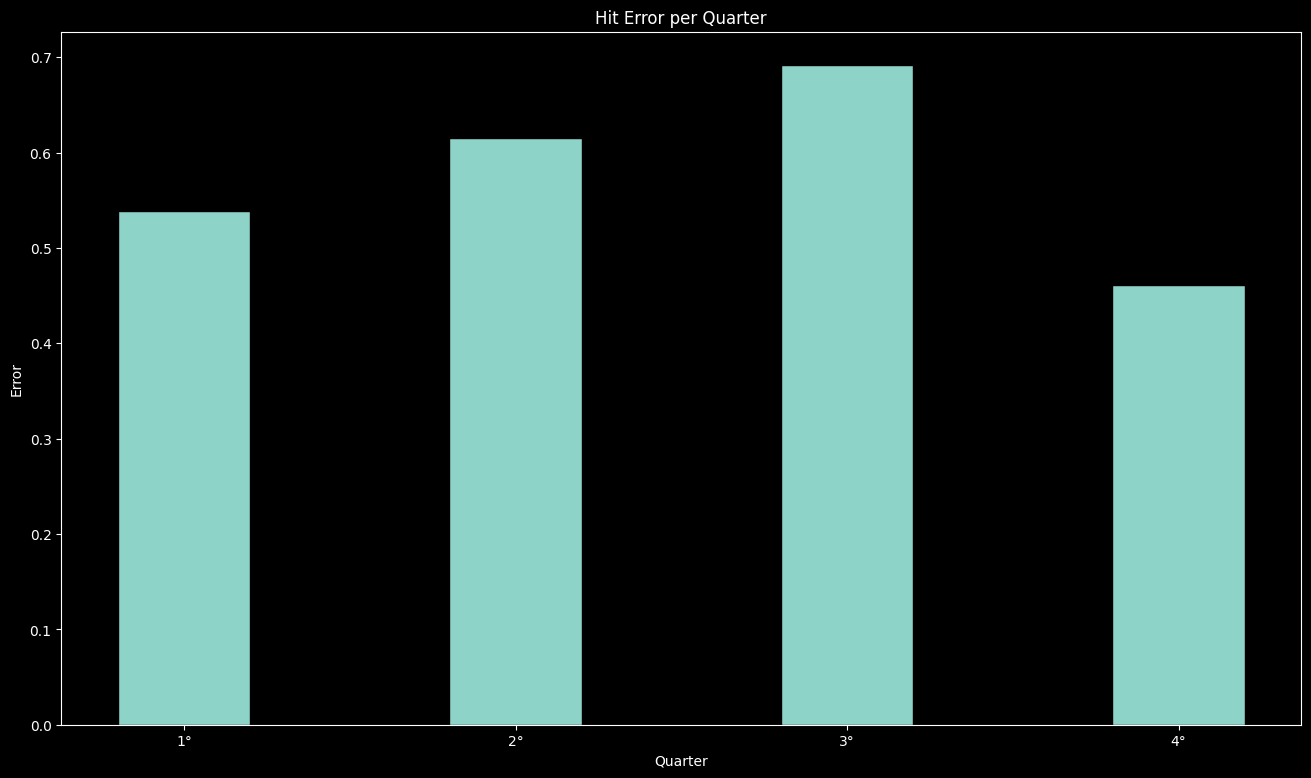

In [ ]:
chainlets=getChainlet(2017)
cluster= Chainlet_Spectral_Clustering(chainlets)
transaction_vol=TranVol(cluster)
av_vol_clus_t=AvDailyTranVol(cluster)
btc_price=getData(2017)
daily_trend_index=getGTrendIndex(2017)
clus_tran_vol_t = ClusTranVol(cluster)
total_tran_vol_t=TotalTranVol(clus_tran_vol_t)
P= getP(clus_tran_vol_t, total_tran_vol_t)
m_fun=getM(daily_trend_index, P)
price_pred=pde_solver(param, m_fun)
factor=getFactor(price_pred, btc_price)
avg_rel_err=relative_error(price_pred, factor, btc_price)[0]
pct_rel_err=relative_error(price_pred, factor, btc_price)[1]

CurrYearPredGraph(price_pred,btc_price, factor, year=2017, err=round(avg_rel_err,4))

pctErrorGraph(pct_rel_err,avg_rel_err)
H_error=Quarter_HitError(price_pred, factor, btc_price)

labels = ['1°', '2°', '3°', '4°']
plt.figure(figsize=(16, 9))
plt.bar(labels, H_error, edgecolor='black', width=0.4)
plt.title('Hit Error per Quarter')
plt.xlabel('Quarter')
plt.ylabel('Error')
plt.show()